#  WildNet: Animal Image Classifier with PyTorch

###  Date: august 26, 2025
### Project By: Basit ali

---

##  Project Overview

This notebook presents a complete deep learning workflow for classifying **safari animals** using a **Convolutional Neural Network (CNN)** built with PyTorch. The task involves training a model on a small image dataset containing four animal classes:

-  Elephant  
-  Giraffe  
-  Lion  
-  Zebra

---

##  Objectives

- Load and preprocess image data using `torchvision.datasets.ImageFolder`.
- Build a custom CNN model (`SafariNet`) from scratch.
- Train and validate the model with real-time tracking of loss and accuracy.
- Evaluate the model using metrics such as **precision**, **recall**, **F1-score**, and **confusion matrix**.
- Visualize predictions and performance to interpret results clearly.
- Save the trained model and use it to classify new test images.





##  1. Import Libraries

I begin by importing all essential libraries required for building, training, and evaluating our CNN model using PyTorch.

- **`torch` / `torchvision`**: Core deep learning libraries for model creation and computer vision utilities.
- **`ImageFolder`, `DataLoader`, `transforms`**: For loading datasets and applying preprocessing steps.
- **`sklearn.metrics`**: To calculate evaluation metrics such as precision, recall, and confusion matrix.
- **`matplotlib`, `seaborn`**: For visualizing model performance during and after training.

- **`PyTorch`** for building and training deep learning models.
-  **`NumPy & Pandas`** for numerical operations and structured reporting.

I also confirm that PyTorch is installed and available:
Libraries imported — ready to use PyTorch 2.7.1+cpu


In [1]:
import os, random, torch, torch.nn as nn, torch.optim as optim
import numpy as np
from collections import Counter
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
print("Libraries imported  ready to use PyTorch", torch.__version__)

Libraries imported  ready to use PyTorch 2.7.1+cpu


## 2 Explore the Dataset

In this step, I explore the dataset by listing the available classes and visualizing one sample image from each category. This helps me verify the dataset structure and get an initial understanding of image quality and variation.


4 classes: ['elephant', 'giraffe', 'lion', 'zebra']


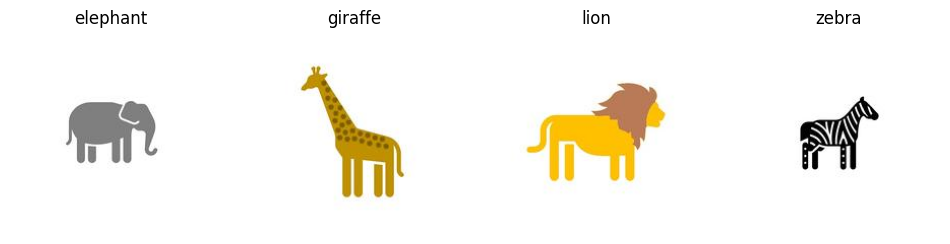

In [3]:

data_path = r'J:\WILD-LIFE\WildNet-Animal-Image-Classifier\Dataset\training'
classes = sorted(os.listdir(data_path))
print(len(classes), 'classes:', classes)

# Show the first image from every class
fig = plt.figure(figsize=(12,4))
for i, cls in enumerate(classes, 1):
    img_file = os.listdir(os.path.join(data_path, cls))[0]
    img_path = os.path.join(data_path, cls, img_file)
    img = plt.imread(img_path)
    ax = fig.add_subplot(1, len(classes), i)
    ax.imshow(img); ax.axis('off'); ax.set_title(cls)
plt.show()

## 3 Prepare the Data – Transformations & Dataloaders

I resize and normalize all images to 224×224 pixels. The training set uses random flips, rotations, and color jitter to augment the data and improve generalization. The dataset is split 80% for training and 20% for validation using a fixed random seed. PyTorch DataLoaders are used to batch and shuffle the data efficiently.


In [5]:
IMG_SZ  = 224
BATCH   = 32

train_tf = T.Compose([
    T.Resize((IMG_SZ, IMG_SZ)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])
val_tf = T.Compose([
    T.Resize((IMG_SZ, IMG_SZ)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

dataset = ImageFolder(data_path, transform=None)
train_len = int(0.8 * len(dataset))
val_len   = len(dataset) - train_len
train_ds, val_ds = random_split(dataset, [train_len, val_len],
                                generator=torch.Generator().manual_seed(42))
train_ds.dataset.transform = train_tf
val_ds.dataset.transform   = val_tf

train_loader = DataLoader(train_ds, BATCH, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   BATCH, shuffle=False, num_workers=2)
print("Training batches:", len(train_loader),
      "Validation batches:", len(val_loader))

Training batches: 10 Validation batches: 3


## 4 Define the CNN Model – SafariNet

I define a custom convolutional neural network `SafariNet` with three convolutional layers followed by max pooling. The model flattens the output and passes it through two fully connected layers with dropout to reduce overfitting. It outputs class logits for the four animal categories. The model is then moved to GPU (if available) for faster training.


In [6]:

class SafariNet(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        # 3×224×224 → 32×112×112
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        # 32×112×112 → 64×56×56
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # 64×56×56 → 128×28×28
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.dropout = nn.Dropout(0.25)
        # fully-connected
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SafariNet().to(device)
print(" SafariNet Architecture\n" + "-"*40)
for name, layer in model.named_children():
    print(f"{name:10s} ➜ {layer}")


 SafariNet Architecture
----------------------------------------
conv1      ➜ Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
pool       ➜ MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
conv2      ➜ Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
conv3      ➜ Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
dropout    ➜ Dropout(p=0.25, inplace=False)
fc1        ➜ Linear(in_features=100352, out_features=256, bias=True)
fc2        ➜ Linear(in_features=256, out_features=4, bias=True)


## 5 Define Loss Function, Optimizer & Scheduler

I use `CrossEntropyLoss` as the loss function since it's ideal for multi-class classification problems. The `Adam` optimizer is chosen for its adaptive learning rate capabilities, making it efficient and robust. A `ReduceLROnPlateau` scheduler is added to reduce the learning rate when validation performance stagnates, helping the model fine-tune as it trains.


In [8]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.3)

## 6 Define Training & Validation Loop – `run_epoch()`

This function handles both training and validation for a single epoch. It processes data batches, computes loss and accuracy, and updates model weights if training. It returns the average loss and accuracy for the entire epoch. The use of `torch.set_grad_enabled()` ensures gradients are only computed during training, improving efficiency.


In [9]:

def run_epoch(loader, training=True):
    model.train(training)
    running_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        if training:
            optimizer.zero_grad()
        with torch.set_grad_enabled(training):
            logits = model(x)
            loss = criterion(logits, y)
            if training:
                loss.backward()
                optimizer.step()
        running_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return running_loss / total, correct / total


## 7 Train the Model & Visualize Performance

The model is trained for up to 30 epochs, tracking training and validation loss and accuracy at each step. If 100% validation accuracy is achieved, training stops early. The best-performing model is saved to disk. After training, we generate two plots:

-  **Loss Curve**: Visualizes how training and validation loss evolve over epochs.
-  **Accuracy Curve**: Shows improvement in accuracy during training and validation.

These visualizations help identify overfitting, underfitting, and general learning trends.


Epoch 01 | Train loss 3.7698 acc 0.4399 | Val loss 0.1856 acc 0.9375
Epoch 02 | Train loss 0.0600 acc 0.9747 | Val loss 0.0003 acc 1.0000
 100% validation accuracy reached at epoch 02 — stopping early.


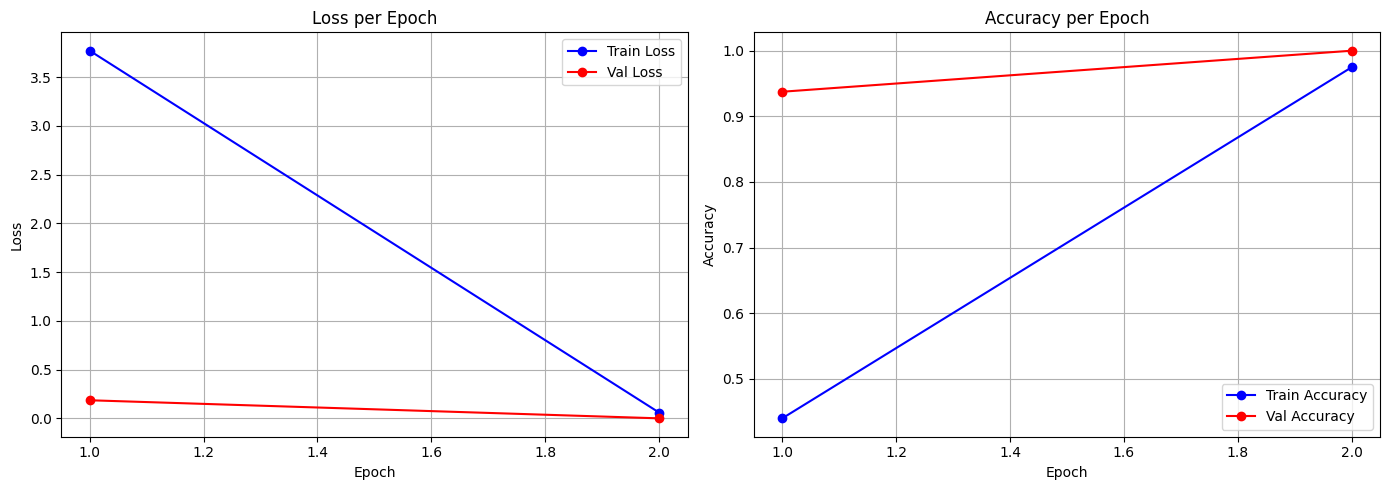

In [10]:

# For tracking
history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

best_acc = 0.0

for epoch in range(1, 31):
    tr_loss, tr_acc = run_epoch(train_loader, training=True)
    val_loss, val_acc = run_epoch(val_loader, training=False)
    scheduler.step(val_loss)

    # Store for plotting
    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f'Epoch {epoch:02d} | '
          f'Train loss {tr_loss:.4f} acc {tr_acc:.4f} | '
          f'Val loss {val_loss:.4f} acc {val_acc:.4f}')

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'safari_best.pt')

    if val_acc >= 1.0:
        print(f' 100% validation accuracy reached at epoch {epoch:02d} — stopping early.')
        break
# Plot loss and accuracy
plt.figure(figsize=(14, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history["epoch"], history["train_loss"], 'bo-', label='Train Loss')
plt.plot(history["epoch"], history["val_loss"], 'ro-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history["epoch"], history["train_acc"], 'bo-', label='Train Accuracy')
plt.plot(history["epoch"], history["val_acc"], 'ro-', label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 8 Evaluate Model Performance

I assess the trained model on the validation dataset using detailed classification metrics and a confusion matrix:

-  **Classification Report**: Displays precision, recall, and F1-score for each class. Also saved to a `classification_report.txt` file.
-  **Confusion Matrix**: Highlights the number of correct and incorrect predictions per class, giving insight into specific misclassifications.

These visualizations are essential for understanding how well the model performs on each class and overall.


              precision  recall  f1-score  support
elephant            1.0     1.0       1.0     12.0
giraffe             1.0     1.0       1.0     18.0
lion                1.0     1.0       1.0     24.0
zebra               1.0     1.0       1.0     26.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     80.0
weighted avg        1.0     1.0       1.0     80.0


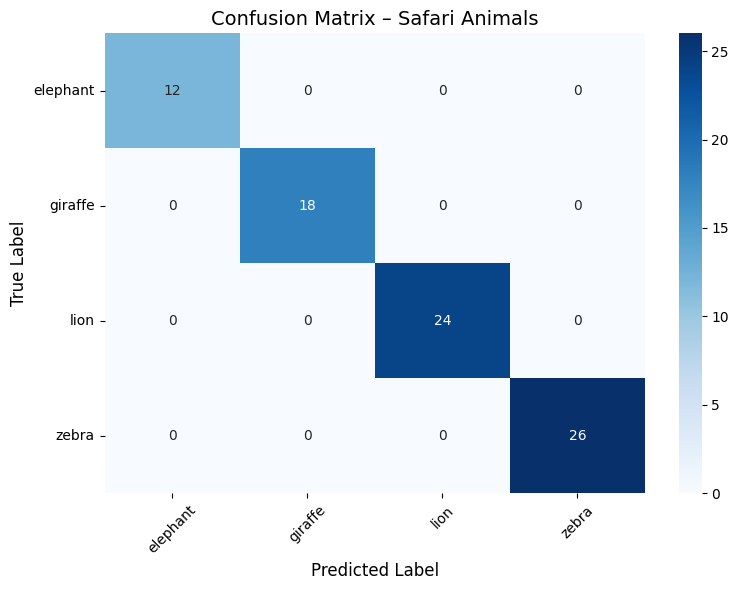

In [9]:

# Load best model
classes = ['elephant', 'giraffe', 'lion', 'zebra']
model.load_state_dict(torch.load('safari_best.pt'))
model.eval()

# Predict on validation set 
all_preds, all_true = [], []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(y.numpy())

# Generate classification report 
report = classification_report(all_true, all_preds, target_names=classes, output_dict=True)
report_text = classification_report(all_true, all_preds, target_names=classes)

# Print formatted table
df_report = pd.DataFrame(report).transpose()
print(df_report.round(2))

# Save report to a text file
with open("classification_report.txt", "w") as f:
    f.write(report_text)

# Confusion matrix 
cm = confusion_matrix(all_true, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix – Safari Animals', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## 9 Visualize Class-wise Performance Metrics

I provide a bar plot to visually compare the **precision**, **recall**, and **F1-score** for each class. This helps to:

-  Quickly identify which classes the model handles best.
-  Spot any imbalances or weaknesses in the classification performance.
-  Make more informed decisions for model improvement or data augmentation.

The grouped bars make it easy to analyze metric distribution across all classes.


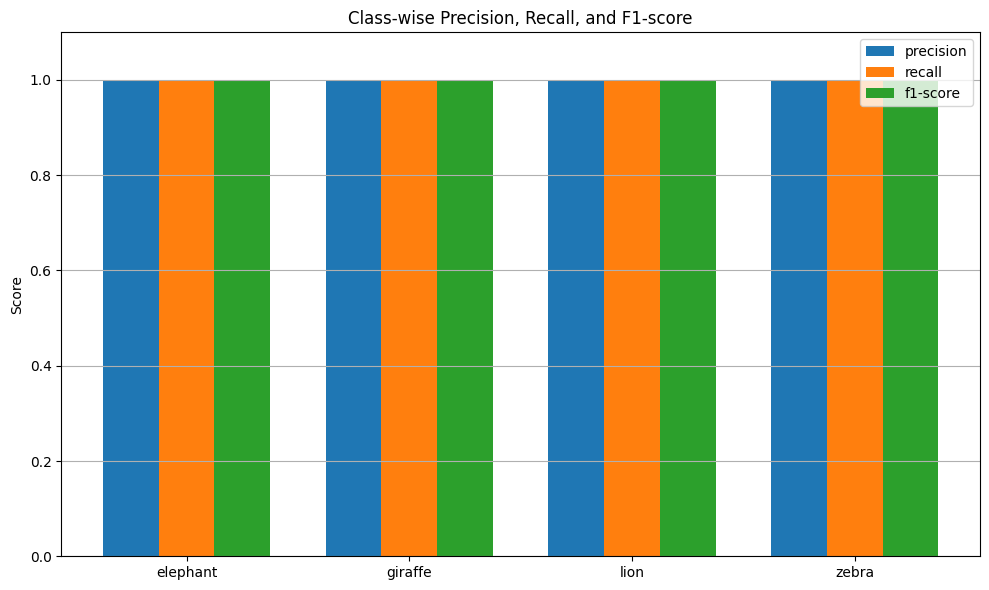

In [10]:
# Bar plot for precision, recall, f1-score
metrics = ['precision', 'recall', 'f1-score']
plt.figure(figsize=(10, 6))

for i, metric in enumerate(metrics):
    values = [report[cls][metric] for cls in classes]
    plt.bar([x + i*0.25 for x in range(len(classes))], values, width=0.25, label=metric)

plt.xticks([x + 0.25 for x in range(len(classes))], classes)
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.title("Class-wise Precision, Recall, and F1-score")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## 10 True vs Predicted Class Distribution

This bar chart compares the **actual** versus **predicted** label counts for each class.

-  Helps verify whether the model is predicting uniformly or biased toward certain classes.
-  Reveals potential data imbalance or overfitting to specific categories.
-  A large mismatch between true and predicted counts may signal misclassification trends.

Use this visualization to audit model predictions against the real dataset distribution.


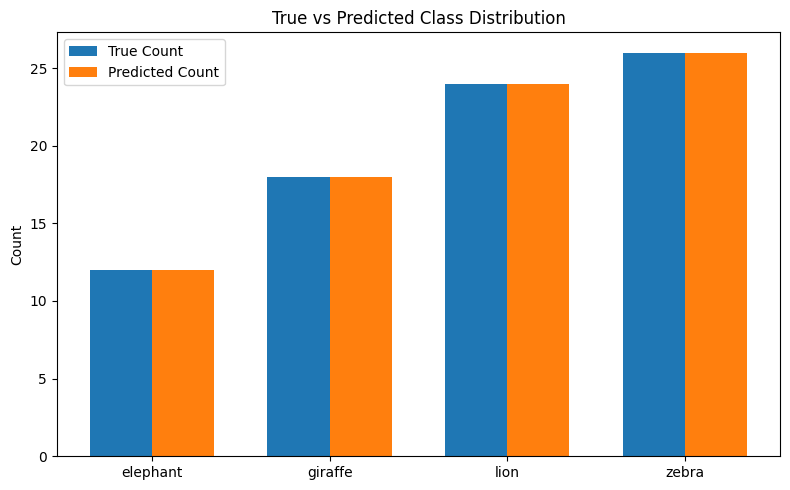

In [11]:

# Count true and predicted labels
true_counts = Counter(all_true)
pred_counts = Counter(all_preds)

labels = np.arange(len(classes))

true_values = [true_counts.get(i, 0) for i in labels]
pred_values = [pred_counts.get(i, 0) for i in labels]

x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, true_values, width, label='True Count')
plt.bar(x + width/2, pred_values, width, label='Predicted Count')
plt.xticks(x, classes)
plt.ylabel('Count')
plt.title('True vs Predicted Class Distribution')
plt.legend()
plt.tight_layout()
plt.show()


##  11 Save the Trained Model

After training and validation, the model is saved for future inference or deployment:

- Uses `torch.save()` to serialize model weights.
- Saved in the `models/` directory as `safari_classifier.pt`.
- Ensures reproducibility and reusability without retraining.

This step is essential for deploying the trained model on new data or integrating it into applications.


In [12]:
import os

# Create the directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Now save the model
torch.save(model.state_dict(), "models/safari_classifier.pt")
print("Model saved as models/safari_classifier.pt")


Model saved as models/safari_classifier.pt


## 12 Use the Trained Model on Test Images

This step demonstrates how to use the trained model to predict unseen test images:

-  Loads the model weights from `safari_best.pt`.
-  Uses a helper function `predict_image()` to infer class labels.
-  Iterates through test images and visualizes predictions using `matplotlib`.
-  Applies the same preprocessing used during training (resize, normalize).

This cell confirms the model's generalization capability beyond the validation set.


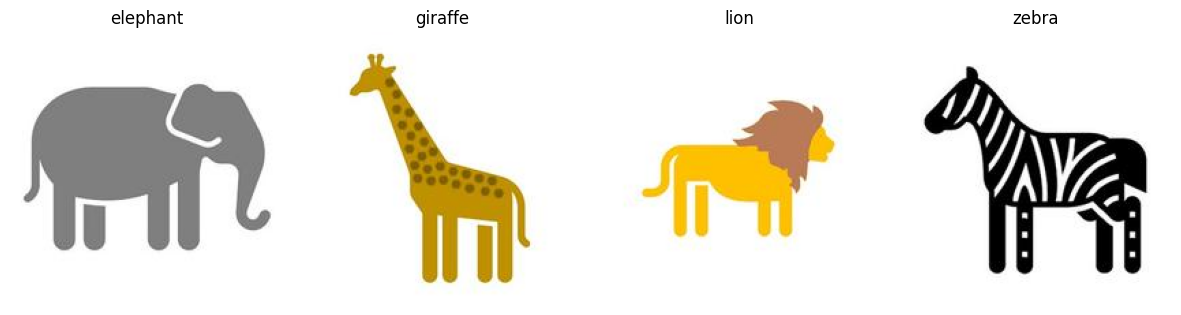

In [15]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from PIL import Image

# paths & transforms 
MODEL_PATH   = 'safari_best.pt'          
TEST_DIR     = r'J:\WILD-LIFE\WildNet-Animal-Image-Classifier\Dataset\test'
IMG_SZ       = 224                       
classes      = ['elephant', 'giraffe', 'lion', 'zebra']

test_tf = T.Compose([
    T.Resize((IMG_SZ, IMG_SZ)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#  load model 
device = torch.device('cpu')
model  = SafariNet(num_classes=len(classes))
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# helper
def predict_image(model, pil_img):
    tensor = test_tf(pil_img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(tensor)
        pred   = logits.argmax(1).item()
    return pred

# plot test predictions 
fig = plt.figure(figsize=(12, 9))
i = 0
for fname in sorted(os.listdir(TEST_DIR)):
    if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue
    i += 1
    img_path = os.path.join(TEST_DIR, fname)
    img_pil  = Image.open(img_path).convert('RGB')
    pred_idx = predict_image(model, img_pil)
    ax = fig.add_subplot(3, 4, i)
    ax.imshow(img_pil); ax.axis('off')
    ax.set_title(classes[pred_idx])
    if i >= 12: break
plt.tight_layout()
plt.show()